In [ ]:
# Importing relevant libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as mp
from sklearn.model_selection import KFold 
from sklearn.model_selection import train_test_split 

In [ ]:
# Uploading excel files for Crude Oil and Heating Oil and indexing/parsing them:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
WTI = pd.read_csv('/content/drive/My Drive/MCTP/WTI.csv', header=0, index_col=0, parse_dates=True)
HOJ = pd.read_csv('/content/drive/My Drive/MCTP/HOJ.csv', header=0, index_col=0, parse_dates=True)

# Merging the two dataframes together into one and look at data since 2003
combined_data = pd.DataFrame({'WTI Close': WTI['Price'], 'HOJ Close': HOJ['Price']})['2003-01-02':]

# Splitting data into train/test with a 80-20 split 
cutoff = round(0.8*len(combined_data.index))
train = combined_data.iloc[:cutoff] 
test = combined_data.iloc[cutoff:]

Mounted at /content/drive


In [ ]:
def strategy(historical_data, lookback, width, stop_loss, chande_lookback, chande_multiplier, atr_periods):
  lookback_months = 1
  monthly_trading_days = 21
  hr_lookback = monthly_trading_days * lookback_months 
  stop_loss_percentage = stop_loss
  take_profit_percentage = 1.5 

  df = historical_data.copy()
  df['hedge_ratio'] = df['WTI Close'].rolling(hr_lookback).corr(df['HOJ Close']) * df['WTI Close'].rolling(hr_lookback).std() / df['HOJ Close'].rolling(hr_lookback).std()
  df['spread'] = df['WTI Close'] - df['hedge_ratio'] * df['HOJ Close']

  # BB calculations
  df['rolling_spread'] = df['spread'].rolling(lookback, min_periods=1).mean() #lookback-day SMA of spread
  df['rolling_spread_std'] = df['spread'].rolling(lookback, min_periods=1).std() #lookback-day rolling STD of spread
  df['upper_band'] = df['rolling_spread'] + (width * df['rolling_spread_std']) #upper = SMA + width * STD
  df['lower_band'] = df['rolling_spread'] - (width * df['rolling_spread_std']) #lower = SMA - width * STD

  # Chandelier exit 
  # chande_lookback = 22
  # chande_multiplier = 3
  df['Lookback high'] = df['spread'].rolling(chande_lookback, min_periods=1).max()
  df['Lookback low'] = df['spread'].rolling(chande_lookback, min_periods=1).min()

    #ATR
  df['lh - c'] = (df['Lookback high'] - df['spread'].shift(-1)).abs()
  df['ll - c'] = (df['Lookback low'] - df['spread'].shift(-1)).abs()
  df['lh - ll'] = (df['Lookback high'] - df['Lookback low']).abs()
  df['TR'] = df[['lh - c', 'll - c', 'lh - ll']].max(axis=1)
  # atr_periods = 14 
  df.loc[df.first_valid_index(), 'ATR'] = df.loc[df.first_valid_index(), 'TR']
  last_date = df.first_valid_index()
  for date in df.index[1:]:
    df.loc[date, 'ATR'] = (df.loc[last_date, 'ATR'] * (atr_periods - 1) + df.loc[date, 'TR']) / atr_periods
    last_date = date

  df['chande_long'] = df['Lookback high'] - (df['ATR'] * chande_multiplier)
  df['chande_short'] = df['Lookback low'] + (df['ATR'] * chande_multiplier) 
  
  

  df['Position WTI'] = np.nan
  first = True
  chande_exit = 0
  for date in df.index:
    #initiate or end position
    trade_amount = 1
    if first:
      last_position = 0
    else:
      last_position = df.loc[last_date, 'Position WTI']

    #don't trade on a position previously exited due to stop loss until we're back inside bands 
    if last_position == "stop loss":
      if not (df.loc[date, 'spread'] >= df.loc[date, 'lower_band']) & (df.loc[date, 'spread'] <= df.loc[date, 'upper_band']):
        continue 
    #if currently in a position 
    elif last_position > 0:
      #chande exit
      chande_exit = df.loc[date, 'chande_short']
      if df.loc[date, 'WTI Close'] <= chande_exit:
        df.loc[date, 'Position WTI'] = "stop loss"
      #enter position or stop loss
      else: 
        if (not np.isnan(df.loc[date, 'upper_band'])):
          trade_amount = df.loc[date, 'spread'] / df.loc[date, 'upper_band']
        if df.loc[date, 'spread'] > df.loc[date, 'upper_band']: 
          #enter position 
          df.loc[date, 'Position WTI'] = max(trade_amount, 1, last_position)
        #simple stop loss
        if (trade_amount <= stop_loss_percentage * last_position):
          df.loc[date, 'Position WTI'] = "stop loss"
    elif last_position < 0:
      #chande exit
      chande_exit = df.loc[date, 'chande_long']
      if df.loc[date, 'WTI Close'] >= chande_exit:
        df.loc[date, 'Position WTI'] = "stop loss"
      #enter position or stop loss
      else:
        if (not np.isnan(df.loc[date, 'lower_band'])):
          x = df.loc[date, 'spread']
          y = df.loc[date, 'lower_band']
          trade_amount = -(x + 2*(y-x)) / y 
        if df.loc[date, 'spread'] < df.loc[date, 'lower_band']:
          #enter position
          df.loc[date, 'Position WTI'] = min(trade_amount, -1, last_position)
        #simple stop loss 
        if (trade_amount >= stop_loss_percentage * last_position):
          # print("stopping loss")
          df.loc[date, 'Position WTI'] = "stop loss" 
    elif last_position == 0:
        if df.loc[date, 'spread'] > df.loc[date, 'upper_band']: 
          if (not np.isnan(df.loc[date, 'upper_band'])):
            trade_amount = df.loc[date, 'spread'] / df.loc[date, 'upper_band']
          #enter position 
          df.loc[date, 'Position WTI'] = max(trade_amount, 1, last_position)
        elif df.loc[date, 'spread'] < df.loc[date, 'lower_band']:
          if (not np.isnan(df.loc[date, 'lower_band'])):
            x = df.loc[date, 'spread']
            y = df.loc[date, 'lower_band']
            trade_amount = -(x + 2*(y-x)) / y 
          #enter position
          df.loc[date, 'Position WTI'] = min(trade_amount, -1, last_position)
        else:
          df.loc[date, 'Position WTI'] = 0
    else:
      #reset stop loss/chande exit upon re-entering bands 
      if (df.loc[date, 'spread'] >= df.loc[date, 'lower_band']) & (df.loc[date, 'spread'] <= df.loc[date, 'upper_band']):
        df.loc[date, 'Position WTI'] = 0

    last_date = date

  # df.replace("stop loss", 0)
  for date in df.index:
    if df.loc[date, 'Position WTI'] == "stop loss":
      df.loc[date, 'Position WTI'] = 0

  df['Position HOJ'] = -df['hedge_ratio'] * df['Position WTI'] 
  df['Position WTI'].fillna(0, inplace=True)
  df['Position HOJ'].fillna(0, inplace=True)

  df['capital'] = 100
  capital = 100
  df['capital'] -= (df['Position HOJ'].diff() * df['HOJ Close'].shift(-1)).replace(to_replace=0, method='ffill')
  df['capital'] -= (df['Position WTI'].diff() * df['WTI Close'].shift(-1)).replace(to_replace=0, method='ffill')

  df['position_value'] = (df['Position WTI'] * df['WTI Close'].shift(-1) + df['Position HOJ'] * df['HOJ Close'].shift(-1))
  df['portfolio_value'] = df['capital'] + df['position_value']
  df['Returns'] = (df['portfolio_value'] - capital) / capital
  df['P&L'] = df['Returns'].diff()
  # print(df['Returns'].sum())

  return df

In [ ]:
train_df = strategy(train, 40, 4.5, 1, 22, 3, 14)
test_df = strategy(test, 40, 4.5, 1, 22, 3, 14)

In [ ]:
r = combined_data['WTI Close'].corr(combined_data['HOJ Close'])
print("Correlation between WTI and HOJ:", r)

Correlation between WTI and HOJ: 0.9671218300394795


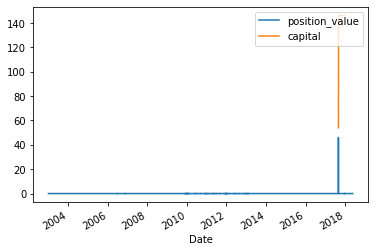

In [ ]:
# train_df['portfolio_value'].plot()
train_df['position_value'].plot()
train_df['capital'].plot(label='capital')
mp.legend(loc='upper right')
mp.show()

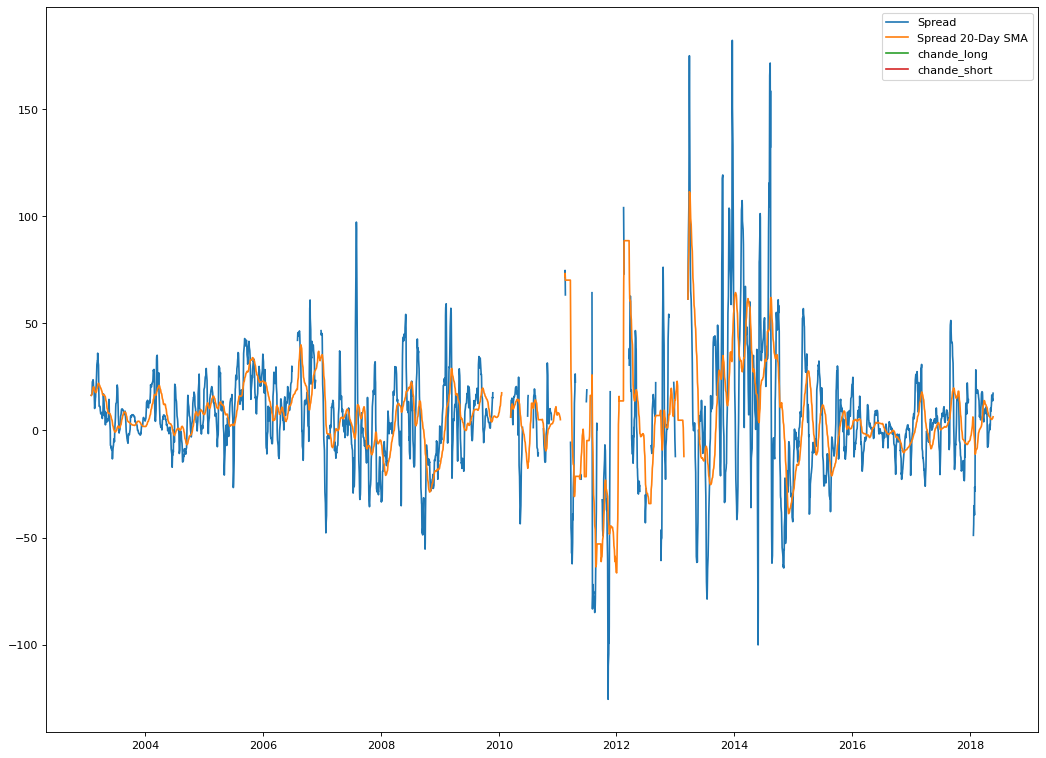

In [ ]:
mp.figure(figsize=(16, 12), dpi=80)
mp.plot(train_df['spread'], label = 'Spread')
mp.plot(train_df['rolling_spread'], label = 'Spread 20-Day SMA')
mp.plot(train_df['upper_band'], label = 'Upper BB')
mp.plot(train_df['lower_band'], label = 'Lower BB')
mp.legend(loc="upper right")


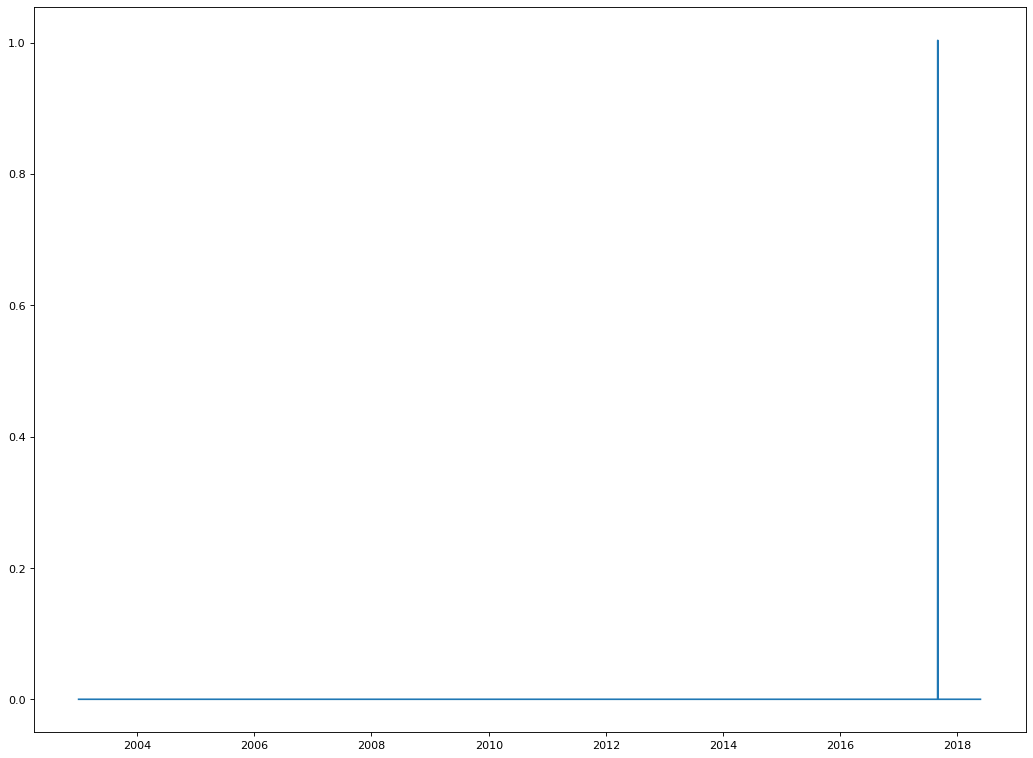

In [ ]:
 mp.figure(figsize=(16, 12), dpi=80)
 mp.plot(train_df['Position WTI'])

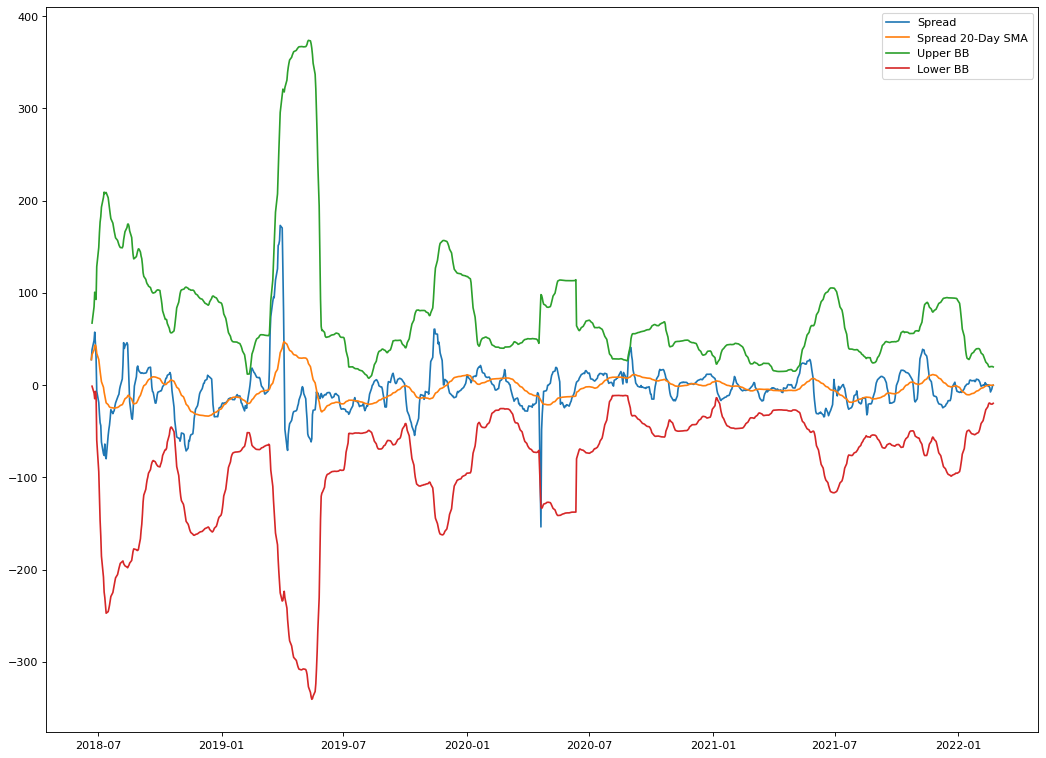

In [ ]:
mp.figure(figsize=(16, 12), dpi=80)
mp.plot(test_df['spread'], label = 'Spread')
mp.plot(test_df['rolling_spread'], label = 'Spread 20-Day SMA')
mp.plot(test_df['upper_band'], label = 'Upper BB')
mp.plot(test_df['lower_band'], label = 'Lower BB')
mp.legend(loc="upper right")

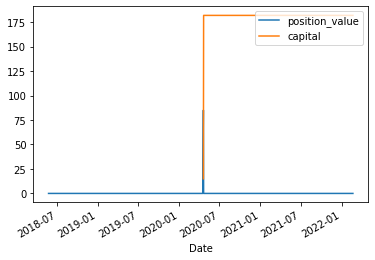

In [ ]:
test_df['position_value'].plot()
test_df['capital'].plot(label='capital')
mp.legend(loc='upper right')
mp.show()

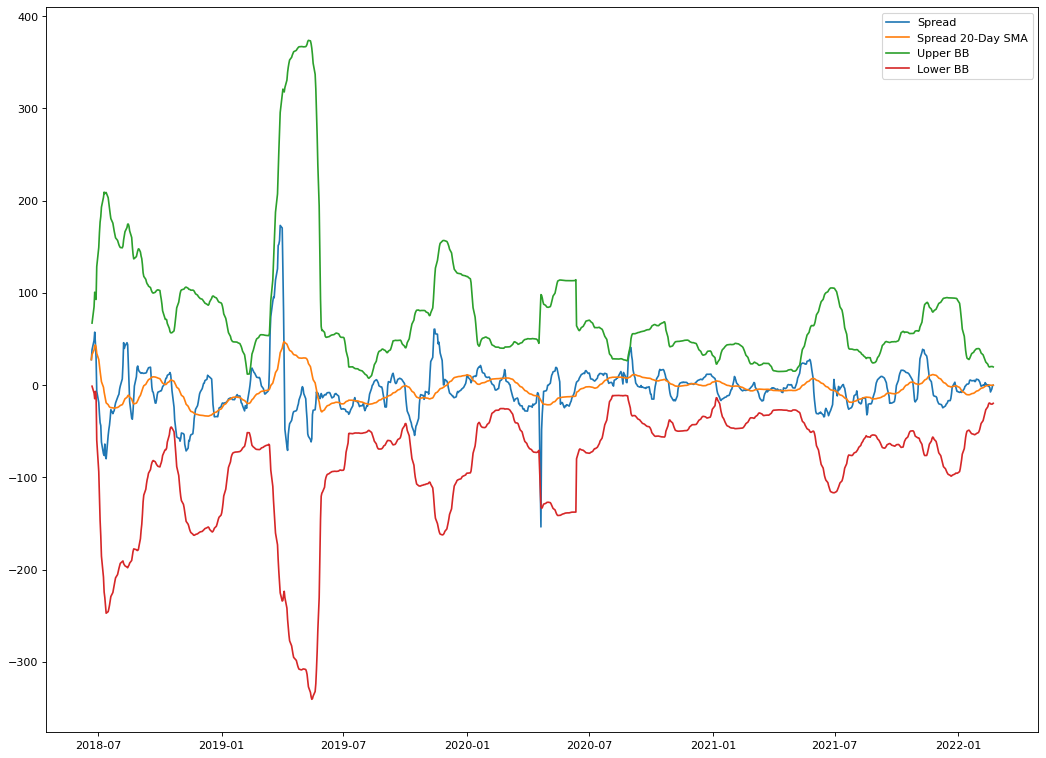

In [ ]:
mp.figure(figsize=(16, 12), dpi=80)
mp.plot(test_df['spread'], label = 'Spread')
mp.plot(test_df['rolling_spread'], label = 'Spread 20-Day SMA')
mp.plot(test_df['upper_band'], label = 'Upper BB')
mp.plot(test_df['lower_band'], label = 'Lower BB')
mp.legend(loc="upper right")

In [ ]:
# Calculating the Sharpe Ratio
# given a Pandas data Series of profits and losses, and a risk-free rate.
# Set the risk-free rate to 10-Year Bond
def get_sharpe(r, rfr=0.0199, n=252):
  if r.std():
    rfr_n = ((rfr+1)**(1/n) - 1)
    return (r.mean() - rfr_n) / r.std() * np.sqrt(n)
  return 0
# Print the Sharpe Ratio of the P&L from my_result
print('Sharpe Ratio Training Data:', get_sharpe(train_df['P&L']))
print('Sharpe Ratio Testing Data:', get_sharpe(test_df['P&L']))
print(test_df['P&L'])

Sharpe Ratio Training Data: 1.7395904635705406
Sharpe Ratio Testing Data: 0.6874146918078551
Date
2018-05-25    NaN
2018-05-27    NaN
2018-05-28    NaN
2018-05-29    NaN
2018-05-30    NaN
             ... 
2022-02-17    0.0
2022-02-18    0.0
2022-02-20    0.0
2022-02-21    0.0
2022-02-22    NaN
Name: P&L, Length: 989, dtype: float64


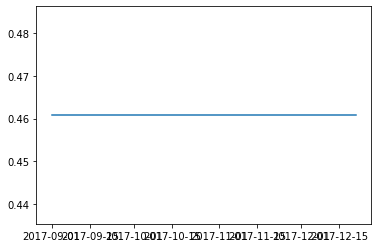

In [ ]:
# Here we provide code to plot the cumulative P&L of my_result.
mp.plot(train_df['P&L'].cumsum())
mp.show()

In [ ]:
def filterNan(input):
    if (np.isnan(input["sharpe"])[0]):
        return False
    else:
        return True 

In [ ]:
def training(train):
  train_results = []
  lookbacks = np.arange(10, 70, 10)
  widths = np.arange(1, 5, 0.5)
  stop_losses = np.arange(0.95, 1, 0.01)
  chande_lookback, chande_multiplier, atr_period = 22, 3, 14 

  for lookback in lookbacks:
    for width in widths:
      for stop_loss in stop_losses:
        df = strategy(train, lookback, width, stop_loss, chande_lookback, chande_multiplier, atr_period) 
        train_results.append({"lookback" : lookback, "width" : width, "stop loss" : stop_loss, "chande_lookback" : chande_lookback, "chande_multiplier" :
                              chande_multiplier, "atr period" : atr_period, "sharpe" : get_sharpe(df['P&L'])})

  sharpes = []
  for entry in train_results:
    sharpes.append(entry['sharpe'])
  sharpes = np.array(sharpes)

  train_results_sorted = sorted(list(filter(lambda x: not (np.isnan(x['sharpe'])), train_results)), key = lambda i: i['sharpe'])
  # print(train_results_sorted)
  maxi_lookback = train_results_sorted[-1]['lookback']
  maxi_width = train_results_sorted[-1]['width']
  maxi_stop_loss = train_results_sorted[-1]['stop loss']
  maxi_clookback = train_results_sorted[-1]["chande_lookback"]
  maxi_cmulti = train_results_sorted[-1]["chande_multiplier"]
  maxi_atrp = train_results_sorted[-1]["atr period"]
  best_sharpe = train_results_sorted[-1]['sharpe']
  # print(maxi_lookback, maxi_width, best_sharpe)
  return (maxi_lookback, maxi_width, maxi_stop_loss, maxi_clookback, maxi_cmulti, maxi_atrp)

In [ ]:
def testing(test, lookback, width, stop_loss, chande_lookback, chande_multiplier, atr_period):
  df = strategy(test, lookback, width, stop_loss, chande_lookback, chande_multiplier, atr_period) 
  test_results = [lookback, width, stop_loss, chande_lookback, chande_multiplier, atr_period, get_sharpe(df['P&L'])]

  return test_results[-1]

In [ ]:
def test_k(k):
  kf = KFold(k, random_state=None) 
  sharpes_k = []
  params = []

  first = True 

  for train_index, test_index in kf.split(combined_data):
    if not first:
      break 
    X_train, X_test = combined_data.iloc[train_index,:], combined_data.iloc[test_index, :] 

    (lookback, width, stop_loss, chande_lookback, chande_multiplier, atr_period) = training(X_train)
    print(lookback, width, stop_loss, chande_lookback, chande_multiplier, atr_period)
    params.append([lookback, width, stop_loss, chande_lookback, chande_multiplier, atr_period])
    sharpes_k.append(testing(test, lookback, width, stop_loss, chande_lookback, chande_multiplier, atr_period))

  print(sharpes_k)
  avg_sharpe_k = sum(sharpes_k) / k
  return avg_sharpe_k, sharpes_k, params 


In [ ]:
avg_sharpe, sharpes_k, params = test_k(5)
with open('/content/drive/My Drive/MCTP/output.txt', 'w') as writefile:
    writefile.write("Start \n")
    writefile.write(str(avg_sharpe))
    writefile.write(str(sharpes_k))
    writefile.write(str(params))

In [ ]:
(test_lookback, test_width, test_stop_loss) = training(train)
print((test_lookback, test_width, test_stop_loss))

sharpe_once = testing(test, test_lookback, test_width, test_stop_loss)
print(sharpe_once)

In [ ]:
kf = KFold(5, random_state=None) 

for train_index, test_index in kf.split(combined_data):
  X_train, X_test = combined_data.iloc[train_index,:], combined_data.iloc[test_index, :] 
  print(X_train.head())
  print(X_test.head())
  break 